# **Data Analysis on Ischaemic Heart Disease**

In 2019, the World Health Organization (WHO) declared that Ischaemic Heart Disease is the leading cause of death worldwide, accounting for 16% of all deaths <a href="#ref-01">[1]</a>. They also mentioned that annual deaths among men were around 15% more than women <a href="#ref-02">[2]</a>.

## Table of Contents

1. <a href="#toc-01">Import Dataset and Data Transformation</a>
2. <a href="#toc-02">Exploratory Data Analysis</a>
3. <a href="#toc-03">Model Creation and Evaluation</a>
5. <a href="#toc-04">Make Test Predications</a>
6. <a href="#toc-05">References</a>

In [606]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import RobustScaler

import warnings
warnings.filterwarnings("ignore")

## Import Dataset and Data Transformation<a id="toc-01"></a>

Dataset for income grouping was taken from <a href="https://www.who.int/docs/default-source/gho-documents/global-health-estimates/ghe2019_cod_methods.pdf">WHO methods and data sources of country-level causes of death (p. 49)</a>.

After reading data from the source, all records with missing data under income_grouping will be dropped as this category is necessary for data analysis.

In [570]:
income_grouping_2019 = pd.read_csv('./datasets/World Bank Income Grouping 2019.csv')

income_grouping_2019.dropna(inplace=True)   # Drop all rows with NaN values
income_grouping_2019.reset_index(inplace=True, drop=True)

income_grouping_2019.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109 entries, 0 to 108
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   region_code      109 non-null    object
 1   region_name      109 non-null    object
 2   country_code     109 non-null    object
 3   country_name     109 non-null    object
 4   income_grouping  109 non-null    object
dtypes: object(5)
memory usage: 4.4+ KB


Dataset for Ischaemic Heart Disease was taken from <a href="https://platform.who.int/mortality/themes/theme-details/topics/indicator-groups/indicator-group-details/MDB/ischaemic-heart-disease">WHO's interactive platform for mortality data</a>.

After reading data from the source, the records are filtered by
- <b>Sex</b>: Male and Female only (removing 'Unknown' and 'All' from the list)
- <b>Age Group</b>: Remove 'All' and 'Unknown'
- <b>Year</b>: Take only data from 1963 to 2019
    - Records before 1963 do not have data for Low Middle Income
    - Records for 2020 is incomplete
- <b>Date Rate per 100,000</b>: Remove records with zero values

In [571]:
ihd_df = pd.read_csv('./datasets/Ischaemic Heart Disease.csv')

ihd_df_filtered = ihd_df.fillna(0)  # Fill all NaN cells with 0
#ihd_df_filtered = ihd_df_filtered.query("sex == ['Male', 'Female'] and age_group != ['[All]', '[Unknown]'] and (year >= 1963 and year < 2020) ")
ihd_df_filtered = ihd_df_filtered.query("sex == ['Male', 'Female'] and age_group != ['[All]', '[Unknown]'] and (year >= 1963 and year < 2020) and death_rate_per_100000 != 0")

ihd_df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 118431 entries, 26 to 296540
Data columns (total 12 columns):
 #   Column                                                Non-Null Count   Dtype  
---  ------                                                --------------   -----  
 0   region_code                                           118431 non-null  object 
 1   region_name                                           118431 non-null  object 
 2   country_code                                          118431 non-null  object 
 3   country_name                                          118431 non-null  object 
 4   year                                                  118431 non-null  int64  
 5   sex                                                   118431 non-null  object 
 6   age_group_code                                        118431 non-null  object 
 7   age_group                                             118431 non-null  object 
 8   num_of_death                               

Merge the necessary fields from Ischeamic Heart Disease and Income Grouping tables

In [572]:
ihd_with_ig_df = ihd_df_filtered[['country_code', 'year', 'sex', 'age_group', 'death_rate_per_100000']].merge(income_grouping_2019[['country_code', 'income_grouping']], on='country_code')

ihd_with_ig_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 117041 entries, 0 to 117040
Data columns (total 6 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   country_code           117041 non-null  object 
 1   year                   117041 non-null  int64  
 2   sex                    117041 non-null  object 
 3   age_group              117041 non-null  object 
 4   death_rate_per_100000  117041 non-null  float64
 5   income_grouping        117041 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 6.3+ MB


Rename the age group category based from Statistics Canada's <a href="https://www.statcan.gc.ca/en/concepts/definitions/age2">Age Categories, Life Cycle Groupings</a>
- <b>Children</b>: 00-14 years
- <b>Youth</b>: 15-24 years
- <b>Adults</b>: 25-64 years
- <b>Seniors</b>: 65 years and over

The records for `Youth` and `Children` are combined in this study.

In [573]:
ihd_with_ig_df['age_group'] = np.where(ihd_with_ig_df['age_group'] == '[0]', 'Children_Youth', ihd_with_ig_df['age_group'])
ihd_with_ig_df['age_group'] = np.where(ihd_with_ig_df['age_group'] == '[1-4]', 'Children_Youth', ihd_with_ig_df['age_group'])
ihd_with_ig_df['age_group'] = np.where(ihd_with_ig_df['age_group'] == '[5-9]', 'Children_Youth', ihd_with_ig_df['age_group'])
ihd_with_ig_df['age_group'] = np.where(ihd_with_ig_df['age_group'] == '[10-14]', 'Children_Youth', ihd_with_ig_df['age_group'])
ihd_with_ig_df['age_group'] = np.where(ihd_with_ig_df['age_group'] == '[15-19]', 'Children_Youth', ihd_with_ig_df['age_group'])
ihd_with_ig_df['age_group'] = np.where(ihd_with_ig_df['age_group'] == '[20-24]', 'Children_Youth', ihd_with_ig_df['age_group'])

ihd_with_ig_df['age_group'] = np.where(ihd_with_ig_df['age_group'] == '[25-29]', 'Adults', ihd_with_ig_df['age_group'])
ihd_with_ig_df['age_group'] = np.where(ihd_with_ig_df['age_group'] == '[30-34]', 'Adults', ihd_with_ig_df['age_group'])
ihd_with_ig_df['age_group'] = np.where(ihd_with_ig_df['age_group'] == '[35-39]', 'Adults', ihd_with_ig_df['age_group'])
ihd_with_ig_df['age_group'] = np.where(ihd_with_ig_df['age_group'] == '[40-44]', 'Adults', ihd_with_ig_df['age_group'])
ihd_with_ig_df['age_group'] = np.where(ihd_with_ig_df['age_group'] == '[45-49]', 'Adults', ihd_with_ig_df['age_group'])
ihd_with_ig_df['age_group'] = np.where(ihd_with_ig_df['age_group'] == '[50-54]', 'Adults', ihd_with_ig_df['age_group'])
ihd_with_ig_df['age_group'] = np.where(ihd_with_ig_df['age_group'] == '[55-59]', 'Adults', ihd_with_ig_df['age_group'])
ihd_with_ig_df['age_group'] = np.where(ihd_with_ig_df['age_group'] == '[60-64]', 'Adults', ihd_with_ig_df['age_group'])

ihd_with_ig_df['age_group'] = np.where(ihd_with_ig_df['age_group'] == '[65-69]', 'Seniors', ihd_with_ig_df['age_group'])
ihd_with_ig_df['age_group'] = np.where(ihd_with_ig_df['age_group'] == '[70-74]', 'Seniors', ihd_with_ig_df['age_group'])
ihd_with_ig_df['age_group'] = np.where(ihd_with_ig_df['age_group'] == '[75-79]', 'Seniors', ihd_with_ig_df['age_group'])
ihd_with_ig_df['age_group'] = np.where(ihd_with_ig_df['age_group'] == '[80-84]', 'Seniors', ihd_with_ig_df['age_group'])
ihd_with_ig_df['age_group'] = np.where(ihd_with_ig_df['age_group'] == '[85+]', 'Seniors', ihd_with_ig_df['age_group'])

ihd_with_ig_df['age_group'].value_counts()

# ihd_with_ig_df.groupby(['age_group', 'sex'])['death_rate_per_100000'].describe()

Adults            60238
Seniors           40366
Children_Youth    16437
Name: age_group, dtype: int64

## Exploratory Data Analysis<a id="toc-02"></a>

### Data Analysis on Income Grouping per Year

Group the records by `income_grouping` then display the summary statistics of `death_rate_per_100000` for each `income_grouping`. 

**NOTE**: WHO didn't provide records for Low Income grouping. Hence, it is excluded from the study.

In [574]:
ihd_with_ig_grp_income = ihd_with_ig_df.groupby(['income_grouping']) 

ihd_with_ig_grp_income['death_rate_per_100000'].describe()

,count,mean,std,min,25%,50%,75%,max
income_grouping,,,,,,,,
High Income,62537.0,610.429194,1307.423631,0.009323,5.410870,76.801331,583.033213,26000.00000
Low Middle Income,12599.0,841.455636,2081.704934,0.021894,4.350052,48.892229,477.720685,20608.95823
Upper Middle Income,41905.0,502.763668,1201.022544,0.011149,4.956629,63.725490,420.256322,19016.29073


Extract the records for `High Income` category. Aggregate them by `year` then get the mean of `death_rate_per_100000` for each year. Create separate dataframe for `year` and `death_rate_per_100000`.

In [575]:
ihd_with_ig_grpby_high_income = ihd_with_ig_grp_income.get_group('High Income')
ihd_with_ig_grpby_high_income_and_year = ihd_with_ig_grpby_high_income[['year', 'death_rate_per_100000']].groupby('year', as_index=False).agg(death_rate_per_100000 = ('death_rate_per_100000', 'mean'))

year_by_high_income = ihd_with_ig_grpby_high_income_and_year['year']
death_rate_per_100000_by_high_income = ihd_with_ig_grpby_high_income_and_year['death_rate_per_100000']

ihd_with_ig_grpby_high_income_and_year.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57 entries, 0 to 56
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   year                   57 non-null     int64  
 1   death_rate_per_100000  57 non-null     float64
dtypes: float64(1), int64(1)
memory usage: 1.0 KB


Extract the records for `Upper Middle Income` category. Aggregate them by `year` then get the mean of `death_rate_per_100000` for each year. Create separate dataframe for `year` and `death_rate_per_100000`.

In [576]:
ihd_with_ig_grpby_upper_middle_income = ihd_with_ig_grp_income.get_group('Upper Middle Income')
ihd_with_ig_grpby_upper_middle_income_and_year = ihd_with_ig_grpby_upper_middle_income[['year', 'death_rate_per_100000']].groupby('year', as_index=False).agg(death_rate_per_100000 = ('death_rate_per_100000', 'mean'))

year_by_upper_mid_income = ihd_with_ig_grpby_upper_middle_income_and_year['year']
death_rate_per_100000_by_upper_mid_income = ihd_with_ig_grpby_upper_middle_income_and_year['death_rate_per_100000']

ihd_with_ig_grpby_upper_middle_income_and_year.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57 entries, 0 to 56
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   year                   57 non-null     int64  
 1   death_rate_per_100000  57 non-null     float64
dtypes: float64(1), int64(1)
memory usage: 1.0 KB


Extract the records for `Low Middle Income` category. Aggregate them by `year` then get the mean of `death_rate_per_100000` for each year. Create separate dataframe for `year` and `death_rate_per_100000`.

In [577]:
ihd_with_ig_grpby_low_middle_income = ihd_with_ig_grp_income.get_group('Low Middle Income')
ihd_with_ig_grpby_low_middle_income_and_year = ihd_with_ig_grpby_low_middle_income[['year', 'death_rate_per_100000']].groupby('year', as_index=False).agg(death_rate_per_100000 = ('death_rate_per_100000', 'mean'))

year_by_low_mid_income = ihd_with_ig_grpby_low_middle_income_and_year['year']
death_rate_per_100000_by_low_mid_income = ihd_with_ig_grpby_low_middle_income_and_year['death_rate_per_100000']

ihd_with_ig_grpby_low_middle_income_and_year.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56 entries, 0 to 55
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   year                   56 non-null     int64  
 1   death_rate_per_100000  56 non-null     float64
dtypes: float64(1), int64(1)
memory usage: 1.0 KB


Plot on the scatterplot the `year` and `death_rate_per_100000` for each incoming grouping.

Text(1987, 1213, '1223.28')

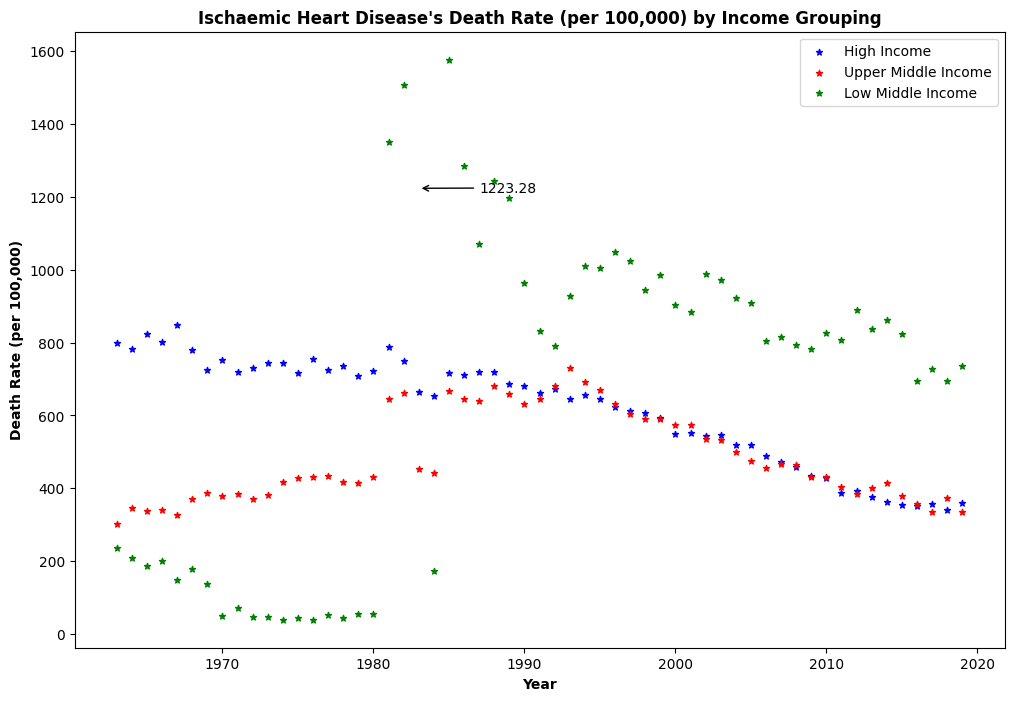

In [578]:
# Plot the graph of Death Rate per 100000 for each Year based on Income Grouping
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
ax.set_xlabel("Year", fontdict={'weight':'bold'})
ax.set_ylabel("Death Rate (per 100,000)", fontdict={'weight':'bold'})
ax.set_title("Ischaemic Heart Disease's Death Rate (per 100,000) by Income Grouping", fontdict={'size':'large', 'weight':'bold'})

ax.scatter(year_by_high_income, death_rate_per_100000_by_high_income, s=20, c='b', label='High Income', marker='*')
ax.scatter(year_by_upper_mid_income, death_rate_per_100000_by_upper_mid_income, s=20, c='r', label='Upper Middle Income', marker='*')
ax.scatter(year_by_low_mid_income, death_rate_per_100000_by_low_mid_income, s=20, c='g', label='Low Middle Income', marker='*')
ax.legend(loc='upper right')

ax.annotate('1223.28', xy=(1983, 1223), xytext=(1987, 1213), arrowprops=dict(arrowstyle='->')) 

Based from the results, death rate of Ischaemic Heart Disease under `High Income` is slowly decreasing over the past years. However, the death rate for `Low Middle Income` has surged in the mid 80's, doubling the value of `High Income`.


### Data Analysis on Sex per Year

Group the records by `sex` then display the summary statistics of `death_rate_per_100000` for each `sex`.

In [579]:
ihd_with_ig_grp_sex = ihd_with_ig_df.groupby(['sex']) 

ihd_with_ig_grp_sex['death_rate_per_100000'].describe()  

,count,mean,std,min,25%,50%,75%,max
sex,,,,,,,,
Female,56843.0,505.323705,1275.534338,0.009741,3.435492,39.952058,364.024864,22333.33333
Male,60198.0,683.080937,1467.658353,0.009323,7.810771,109.520838,647.932954,26000.00000


Extract the records for `Male`. Aggregate them by `year` then get the mean of `death_rate_per_100000` for each year. Create separate dataframe for `year` and `death_rate_per_100000`.

In [580]:
df_grpby_male = ihd_with_ig_grp_sex.get_group('Male')
df_grpby_male_and_year = df_grpby_male[['year', 'death_rate_per_100000']].groupby('year', as_index=False).agg(death_rate_per_100000 = ('death_rate_per_100000', 'mean'))

year_by_male = df_grpby_male_and_year['year']
death_rate_per_100000_by_male = df_grpby_male_and_year['death_rate_per_100000']

df_grpby_male_and_year.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57 entries, 0 to 56
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   year                   57 non-null     int64  
 1   death_rate_per_100000  57 non-null     float64
dtypes: float64(1), int64(1)
memory usage: 1.0 KB


Extract the records for `Female`. Aggregate them by `year` then get the mean of `death_rate_per_100000` for each year. Create separate dataframe for `year` and `death_rate_per_100000`.

In [581]:
df_grpby_female = ihd_with_ig_grp_sex.get_group('Female')
df_grpby_female_and_year = df_grpby_female[['year', 'death_rate_per_100000']].groupby('year', as_index=False).agg(death_rate_per_100000 = ('death_rate_per_100000', 'mean'))

year_by_female = df_grpby_female_and_year['year']
death_rate_per_100000_by_female = df_grpby_female_and_year['death_rate_per_100000']

df_grpby_female_and_year.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57 entries, 0 to 56
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   year                   57 non-null     int64  
 1   death_rate_per_100000  57 non-null     float64
dtypes: float64(1), int64(1)
memory usage: 1.0 KB


Plot on the scatterplot the `year` and `death_rate_per_100000` for each gender.

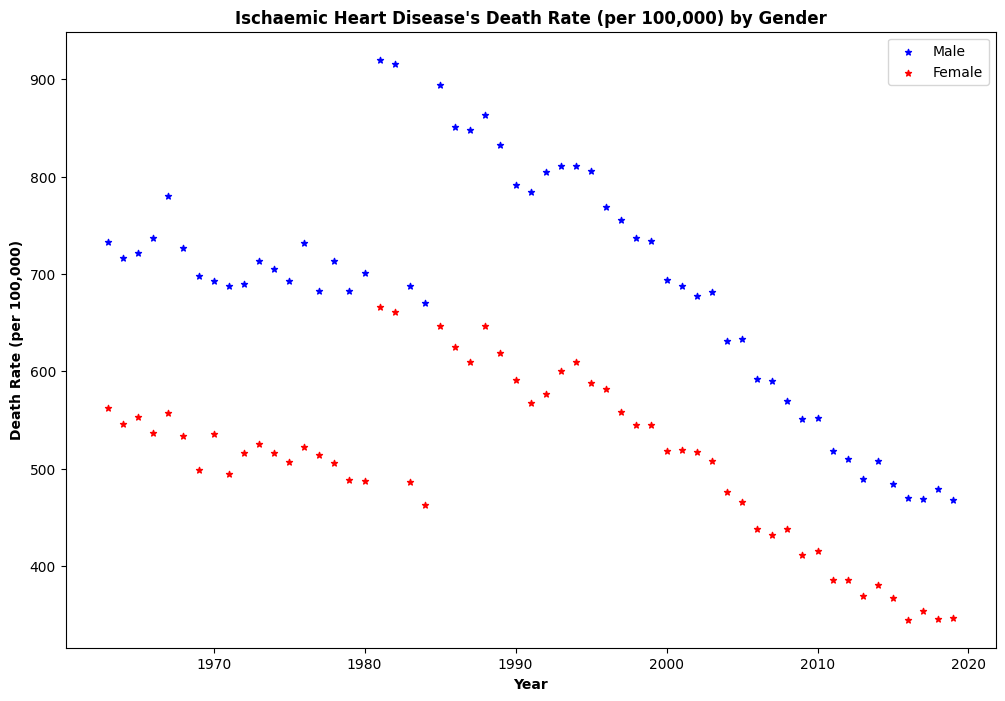

In [582]:
# Plot the graph of Death Rate per 100000 for each Year based on Sex
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
ax.set_xlabel("Year", fontdict={'weight':'bold'})
ax.set_ylabel("Death Rate (per 100,000)", fontdict={'weight':'bold'})
ax.set_title("Ischaemic Heart Disease's Death Rate (per 100,000) by Gender", fontdict={'size':'large', 'weight':'bold'})

ax.scatter(year_by_male, death_rate_per_100000_by_male, s=20, c='b', label='Male', marker='*')
ax.scatter(year_by_female, death_rate_per_100000_by_female, s=20, c='r', label='Female', marker='*')
ax.legend(loc='upper right')

Based from the results, `Male` has a higher death rate on Ischaemic Heart Disease as compared to `Female` though the mortality rate has decreased for both gender over the years.

## Model Creation and Evaluation<a id="toc-03"></a>

### Data Preparation: Converting Categorical Features

Check the frequency counts of `income_grouping`, `sex` and `age_group`.

In [583]:
ihd_with_ig_df['income_grouping'].value_counts()

High Income            62537
Upper Middle Income    41905
Low Middle Income      12599
Name: income_grouping, dtype: int64

In [584]:
ihd_with_ig_df['sex'].value_counts()

Male      60198
Female    56843
Name: sex, dtype: int64

In [585]:
ihd_with_ig_df['age_group'].value_counts()

Adults            60238
Seniors           40366
Children_Youth    16437
Name: age_group, dtype: int64

Convert `income_grouping`, `sex` and `age_group` to dummy variables with 0 or 1 as the value.

In [586]:
income_grouping_df = pd.get_dummies(ihd_with_ig_df['income_grouping'])
income_grouping_df.columns = ['high_income', 'low_middle_income', 'upper_middle_income']
income_grouping_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 117041 entries, 0 to 117040
Data columns (total 3 columns):
 #   Column               Non-Null Count   Dtype
---  ------               --------------   -----
 0   high_income          117041 non-null  uint8
 1   low_middle_income    117041 non-null  uint8
 2   upper_middle_income  117041 non-null  uint8
dtypes: uint8(3)
memory usage: 1.2 MB


In [587]:
male_gender_df = pd.get_dummies(ihd_with_ig_df['sex'], drop_first=True)
male_gender_df.columns = ['male_gender']
male_gender_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 117041 entries, 0 to 117040
Data columns (total 1 columns):
 #   Column       Non-Null Count   Dtype
---  ------       --------------   -----
 0   male_gender  117041 non-null  uint8
dtypes: uint8(1)
memory usage: 1.0 MB


In [588]:
age_grouping_df = pd.get_dummies(ihd_with_ig_df['age_group'])
age_grouping_df.columns = ['adults', 'children_youth', 'seniors']
age_grouping_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 117041 entries, 0 to 117040
Data columns (total 3 columns):
 #   Column          Non-Null Count   Dtype
---  ------          --------------   -----
 0   adults          117041 non-null  uint8
 1   children_youth  117041 non-null  uint8
 2   seniors         117041 non-null  uint8
dtypes: uint8(3)
memory usage: 1.2 MB


Create a dummy dataframe. Drop `income_grouping`, `sex` and `age_group` and all unnecessary column(s) from the dummy dataframe.

In [589]:
ihd_with_ig_df_dummy = ihd_with_ig_df.copy()
ihd_with_ig_df_dummy.drop(['country_code', 'sex', 'income_grouping', 'year', 'age_group'], axis=1, inplace=True)

ihd_with_ig_df_dummy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 117041 entries, 0 to 117040
Data columns (total 1 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   death_rate_per_100000  117041 non-null  float64
dtypes: float64(1)
memory usage: 1.8 MB


Concatenate in the dummy dataframe the dataframe (with dummy variables) created for `income_grouping`, `sex` and `age_group`.

In [590]:
ihd_with_ig_df_dummy = pd.concat([ihd_with_ig_df_dummy, male_gender_df, age_grouping_df, income_grouping_df], axis=1, verify_integrity=True)
ihd_with_ig_df_dummy.head(5)

,death_rate_per_100000,male_gender,adults,children_youth,seniors,high_income,low_middle_income,upper_middle_income
0,0.617665,1,0,1,0,0,0,1
1,0.662252,1,0,1,0,0,0,1
2,4.040404,1,1,0,0,0,0,1
3,5.564388,1,1,0,0,0,0,1
4,5.213764,1,1,0,0,0,0,1


Check for independence between columns. The intensity of the feature's dependency is measured by the cell's color (more dependency -> darker color)

<AxesSubplot: >

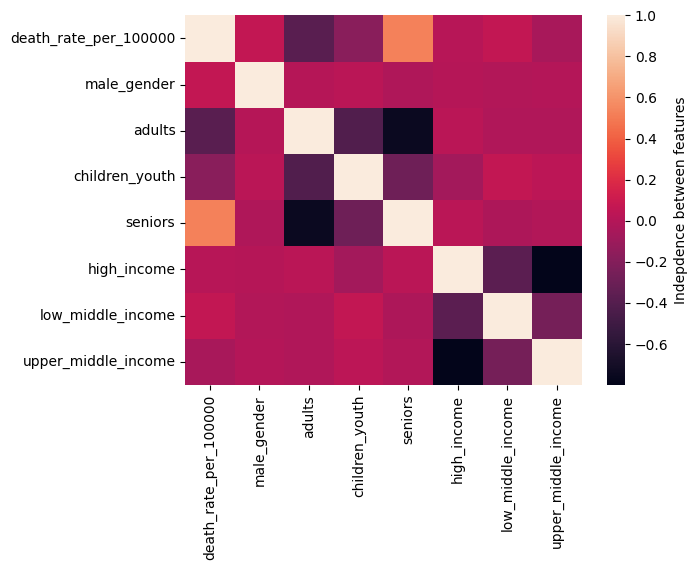

In [591]:
# Check for independence between features
sb.heatmap(ihd_with_ig_df_dummy.corr(), cbar_kws={'label': 'Indepdence between features'})

### Function Declaration

In [697]:
def evaluateModel(model, X_train, X_test, y_train, y_test):
    '''
    This method evaluate the Logistic Regression model and provide clasification report,
    confusion matrix and precision score
    '''
    y_pred_test = model.predict(X_test)
    
    print(f'Model score: {model.score(X_test, y_test)}')
    print()

    # Classification report without cross-validation
    print("Classification Report")
    print(classification_report(y_test, y_pred_test))
    print()

    # k-fold cross-validation and confusion matrices
    y_train_pred = cross_val_predict(model, X_train, y_train, cv=5)

    cm = confusion_matrix(y_train, y_train_pred)
    cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], index=['Predict Positive:1', 'Predict Negative:0'])
    sb.heatmap(cm_matrix, annot=True, fmt='d')
    plt.title('Confusion Matrix')

    TP = cm[0,0]
    TN = cm[1,1]
    FP = cm[0,1]
    FN = cm[1,0]

    classification_accuracy = (TP + TN) / float(TP + TN + FP + FN)
    print('Classification accuracy : {0:0.4f}'.format(classification_accuracy))

    classification_error = (FP + FN) / float(TP + TN + FP + FN)
    print('Classification error : {0:0.4f}'.format(classification_error))

    print(f"Precision Score: {precision_score(y_train, y_train_pred)}")

### Model Creation and Evaluation for each Age Group

In [708]:
X_train, X_test, y_train, y_test = train_test_split(ihd_with_ig_df_dummy.drop(['adults', 'children_youth', 'seniors'], axis=1), age_grouping_df['seniors'], test_size=0.3, random_state=0)

print(f"No. of train datasets: x={X_train.shape} y={y_train.shape}")
print(f"No. of test datasets: x={X_test.shape} y={y_test.shape}\n")

model_seniors = LogisticRegression(solver='lbfgs')
model_seniors.fit(X_train, y_train)

No. of train datasets: x=(81928, 5) y=(81928,)
No. of test datasets: x=(35113, 5) y=(35113,)



LogisticRegression()

Model score: 0.9032836841056019

Classification Report
              precision    recall  f1-score   support

           0       0.90      0.96      0.93     23183
           1       0.91      0.79      0.85     11930

    accuracy                           0.90     35113
   macro avg       0.91      0.88      0.89     35113
weighted avg       0.90      0.90      0.90     35113


Classification accuracy : 0.9030
Classification error : 0.0970
Precision Score: 0.9152645449016825


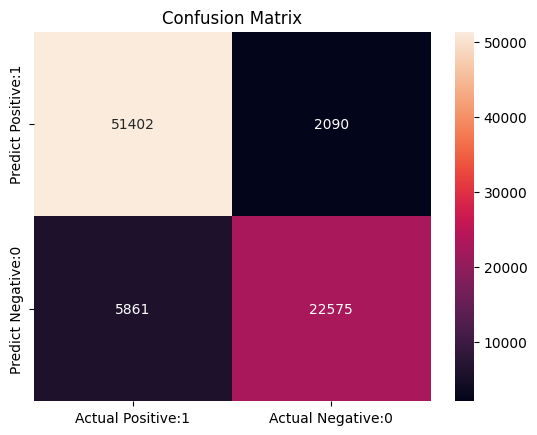

In [709]:
evaluateModel(model_seniors, X_train, X_test, y_train, y_test)

In [710]:
X_train, X_test, y_train, y_test = train_test_split(ihd_with_ig_df_dummy.drop(['adults', 'children_youth', 'seniors'], axis=1), age_grouping_df['adults'], test_size=0.3, random_state=0)

print(f"No. of train datasets: x={X_train.shape} y={y_train.shape}")
print(f"No. of test datasets: x={X_test.shape} y={y_test.shape}\n")

model_adults = LogisticRegression(solver='lbfgs')
model_adults.fit(X_train, y_train)

No. of train datasets: x=(81928, 5) y=(81928,)
No. of test datasets: x=(35113, 5) y=(35113,)



LogisticRegression()

Model score: 0.7670948081906986

Classification Report
              precision    recall  f1-score   support

           0       0.87      0.60      0.71     16792
           1       0.71      0.92      0.80     18321

    accuracy                           0.77     35113
   macro avg       0.79      0.76      0.76     35113
weighted avg       0.79      0.77      0.76     35113


Classification accuracy : 0.7643
Classification error : 0.2357
Precision Score: 0.707682698313554


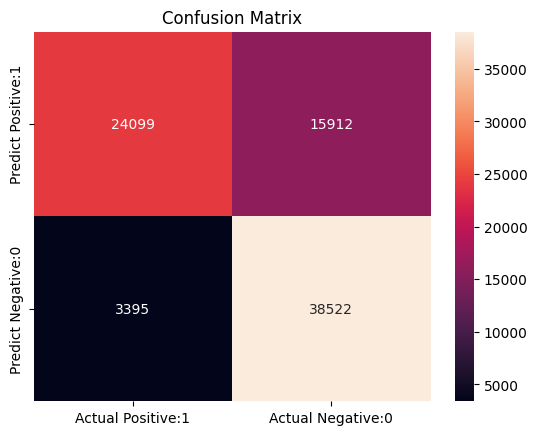

In [711]:
evaluateModel(model_adults, X_train, X_test, y_train, y_test)

In [712]:
X_train, X_test, y_train, y_test = train_test_split(ihd_with_ig_df_dummy.drop(['adults', 'children_youth', 'seniors'], axis=1), age_grouping_df['children_youth'], test_size=0.3, random_state=0)

print(f"No. of train datasets: x={X_train.shape} y={y_train.shape}")
print(f"No. of test datasets: x={X_test.shape} y={y_test.shape}\n")

model_children_youth = LogisticRegression(solver='lbfgs')
model_children_youth.fit(X_train, y_train)

No. of train datasets: x=(81928, 5) y=(81928,)
No. of test datasets: x=(35113, 5) y=(35113,)



LogisticRegression()

Model score: 0.9364053199669639

Classification Report
              precision    recall  f1-score   support

           0       0.97      0.96      0.96     30251
           1       0.76      0.79      0.77      4862

    accuracy                           0.94     35113
   macro avg       0.86      0.87      0.87     35113
weighted avg       0.94      0.94      0.94     35113


Classification accuracy : 0.9368
Classification error : 0.0632
Precision Score: 0.7672766775298738


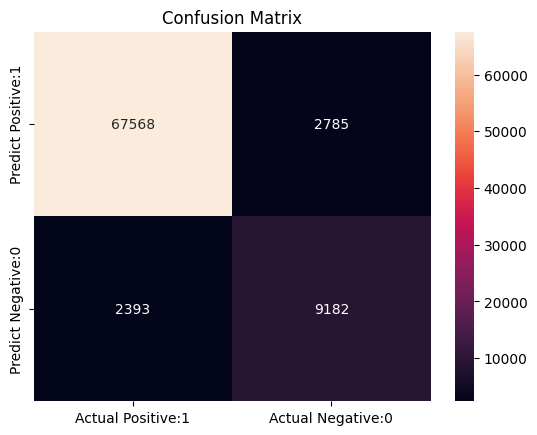

In [713]:
evaluateModel(model_children_youth, X_train, X_test, y_train, y_test)

## Make Test Prediction<a id="toc-04"></a>

In [768]:
def getPrediction(age_group, model, input):

    df = np.array(input).reshape(1,-1)

    percentage = round(model.predict_proba(df)[0][1] * 100, 2)
    print(f"{age_group}: {percentage}%")


def testPrediction(models: dict, input: list):
    print(f"Gender: {'Male' if input[1] == '1' else 'Female'}")

    income_grouping = None
    if input[2] == 1:
        income_grouping = "High Income"
    elif input[3] == 1:
        income_grouping = "Upper Middle Income"
    elif input[4] == 1:
        income_grouping = "Low Middle Income"

    print(f"Income Grouping: {income_grouping}")
    print(f"Death Rate (per 100,000): {input[0]}")
    print()

    print("Probability that the data belongs to a specific age group:\n")

    for elem in models.items():
        getPrediction(elem[0], elem[1], input)


In [769]:
date_rate = 700
male_gender = 1
high_income = 0
upper_middle_income = 0
low_middle_income = 1

testPrediction({ 'Children/Youth': model_children_youth, 'Adults': model_adults, 'Seniors': model_seniors }, [date_rate, male_gender, high_income, upper_middle_income, low_middle_income])

Gender: Female
Income Grouping: Low Middle Income
Death Rate (per 100,000): 700

Probability that the data belongs to a specific age group:

Children/Youth: 0.0%
Adults: 16.8%
Seniors: 93.28%


In [770]:
date_rate = 120
male_gender = 1
high_income = 0
upper_middle_income = 0
low_middle_income = 1

testPrediction({ 'Children/Youth': model_children_youth, 'Adults': model_adults, 'Seniors': model_seniors }, [date_rate, male_gender, high_income, upper_middle_income, low_middle_income])

Gender: Female
Income Grouping: Low Middle Income
Death Rate (per 100,000): 120

Probability that the data belongs to a specific age group:

Children/Youth: 0.0%
Adults: 64.17%
Seniors: 6.84%


In [771]:
date_rate = 1
male_gender = 1
high_income = 0
upper_middle_income = 0
low_middle_income = 0

testPrediction({ 'Children/Youth': model_children_youth, 'Adults': model_adults, 'Seniors': model_seniors }, [date_rate, male_gender, high_income, upper_middle_income, low_middle_income])

Gender: Female
Income Grouping: None
Death Rate (per 100,000): 1

Probability that the data belongs to a specific age group:

Children/Youth: 79.58%
Adults: 71.81%
Seniors: 3.27%


## References<a id="toc-06"></a>

- <a id="ref-01">https://www.who.int/news-room/fact-sheets/detail/the-top-10-causes-of-death</a>
- <a id="ref-02">https://www.who.int/data/gho/data/themes/mortality-and-global-health-estimates</a>
- <a id="ref-03">https://www.who.int/docs/default-source/gho-documents/global-health-estimates/ghe2019_cod_methods.pdf</a>
- <a id="ref-03">https://platform.who.int/mortality/themes/theme-details/topics/indicator-groups/indicator-group-details/MDB/ischaemic-heart-disease</a>